In [1]:
%load_ext autoreload
%autoreload 2


In [18]:
#load modules
import datacube
from datacube.storage import masking
from datacube import Datacube
from datetime import datetime
from skimage import exposure

import rasterio
from datacube_stats.statistics import GeoMedian
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr


import geopandas as gpd
from sklearn.ensemble import ExtraTreesClassifier
import datacube_stats
import os
# Replace '156' and 'ck9738' with the path to your own home directory on the VDI
s2aws = Datacube(config='/home/547/ck9738/datacube-s2.conf')

ImportError: cannot import name 'three_band_array'

In [3]:

# import the necessary packages
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
import argparse

In [4]:
#define nessisary gotiff handeling fuctions

import xarray, rasterio, numpy as np
def numpy_to_xarray(array, geobox, name=None):
    """Utility to convert ndarray to DataArray, using a datacube.model.GeoBox"""
    coords=[xarray.Coordinate(x, geobox.coords[x].values, attrs=dict(units=geobox.coords[x].units)) 
            for x in geobox.dims]
    return xarray.DataArray(array, coords=coords, attrs=dict(crs=geobox.crs), name=name)

def geopandas_to_xarray(table, geobox, name=None):
    """Rasterise (with reprojection)"""
    array = rasterio.features.rasterize(shapes=table.to_crs(geobox.crs._crs.ExportToProj4()).geometry,
                                        out_shape=(geobox.height, geobox.width),
                                        transform=geobox.affine)
    return numpy_to_xarray(array, geobox, name)

def rasterfile_to_xarray(file, geobox, name=None, nodata=True, num_bands=(1), X_band= 1):
    """Blit like
    """
    with rasterio.open(file) as src:

        #|assert src.indexes == num_bands # assume single band
        band = rasterio.band(src, X_band) # do not attempt to read entire extent into memory
        array = np.empty((geobox.height, geobox.width), dtype=band.dtype)
        rasterio.warp.reproject(source=band,
                                destination=array,
                                dst_crs=geobox.crs.crs_str,
                                dst_transform=geobox.affine,
                                dst_nodata=nodata)
    return numpy_to_xarray(array, geobox, name)

In [5]:
"""square 60 -149  'lat': (-33.107410, -33.216838),
near parks      'lon': (148.264306, 148.470191),"""

"square 60 -149  'lat': (-33.107410, -33.216838),\nnear parks      'lon': (148.264306, 148.470191),"

In [6]:
#load sentinal data
sensors= ['s2a_ard_granule'] #pick the sentinal satelites you want

bands_of_int =['blue', 'green', 'red'
             #'rededge1', 
             #'rededge2', 'rededge3', 'nir1', 'nir2', 'swir1', 'swir2', 'pixel_quality'
              ] #pick the sentinal bands that you want, here i am just using visible light  

query = {
        'lat': (-35.219946, -35.404461),
        'lon': (149.12468, 149.413767),
        'output_crs': 'EPSG:3577',
        'resolution': (-10, 10),
        'time':('2016-01-01', '2016-03-30')
        }
      
# use s2b_ard_granule 	 for S2B
data_sent = s2aws.load(product='s2a_ard_granule', measurements=bands_of_int, group_by='solar_day', **query)
#clear_pixels = np.logical_and(data_sent.pixel_quality != 2, data_sent.pixel_quality != 3)

Sentinal_time = data_sent.isel(time=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


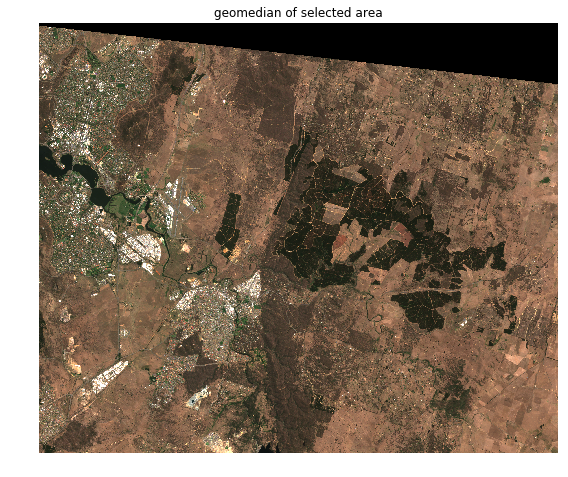

In [7]:
#plot RGB image
#Prepare geomedian imagery for plotting

rgb = Sentinal_time.to_array(dim='color').sel(color=[
    'red','green', 'blue']).transpose('y', 'x', 'color')
fake_saturation = 2000.0  #you may need to adjust this to get a clear image. higher numbers will make it darker, 
                                                                            #lower will make it ligher
rgb = rgb.astype('double')
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

fig = plt.figure(figsize =(8,8)) #edit size of plot 
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #set border dimensions
fig.patch.set_facecolor('white') #make border white 
fig.patch.set_alpha(0.99)#ensure border white
plt.axis('off')#remove axis 
plt.title('geomedian of selected area') #add title
plt.imshow(scaled, interpolation = 'nearest') #create image

In [8]:
group_smad_green = {}
band_list = [1,2,3]

#load smad/green product for area
for band in band_list:#49 -129

    data = rasterfile_to_xarray('/g/data/u46/users/dxr251/woody-v6/woody_62_-159.tif', data_sent.geobox, num_bands=(1,2,3), X_band=band)
    group_smad_green[band] = data

/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  import sys


In [9]:
#concatinate into an xarray
data_smad_green = xr.concat([group_smad_green[1],group_smad_green[2],group_smad_green[3]], 'band')#,
ori_n,ori_y,ori_x=data_smad_green.shape

data_smad_green=data_smad_green.transpose('y', 'x', 'band')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


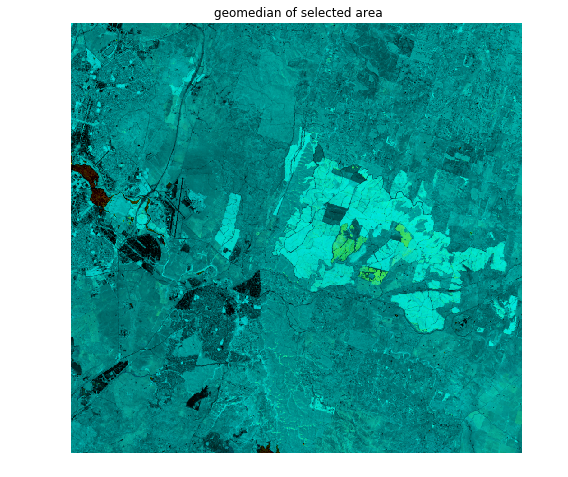

In [10]:
#plot pre-cluster image of smad tree product
#Prepare geomedian imagery for plotting

rgb = data_smad_green.sel(band=[
    0,1,2]).transpose('y', 'x', 'band')
fake_saturation = 1000.0  #you may need to adjust this to get a clear image. higher numbers will make it darker, 
                                                                            #lower will make it ligher
rgb = rgb.astype('double')
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

fig = plt.figure(figsize =(8,8)) #edit size of plot 
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #set border dimensions
fig.patch.set_facecolor('white') #make border white 
fig.patch.set_alpha(0.99)#ensure border white
plt.axis('off')#remove axis 
plt.title('geomedian of selected area') #add title
plt.imshow(scaled, interpolation = 'nearest') #create image

In [11]:
data_smad_green[2]

<xarray.DataArray (x: 2877, band: 3)>
array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       ...,
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]], dtype=float32)
Coordinates:
    y        float64 -3.951e+06
  * x        (x) float64 1.548e+06 1.548e+06 1.548e+06 1.548e+06 1.548e+06 ...
Dimensions without coordinates: band
Attributes:
    crs:      EPSG:3577

In [12]:
# loop over the number of segments
numSegments=600
    # apply SLIC and extract (approximately) the supplied number
    # of segments
segments = slic(data_smad_green, n_segments = numSegments,compactness=10, sigma = 2, multichannel=True, enforce_connectivity=True)
 
    # show the output of SLIC
# fig = plt.figure("Superpixels -- %d segments" % (numSegments))
# ax = fig.add_subplot(1,1,1)
# ax.imshow(mark_boundaries(scaled, segments))
# plt.axis("off")
 
# show the plots
# plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


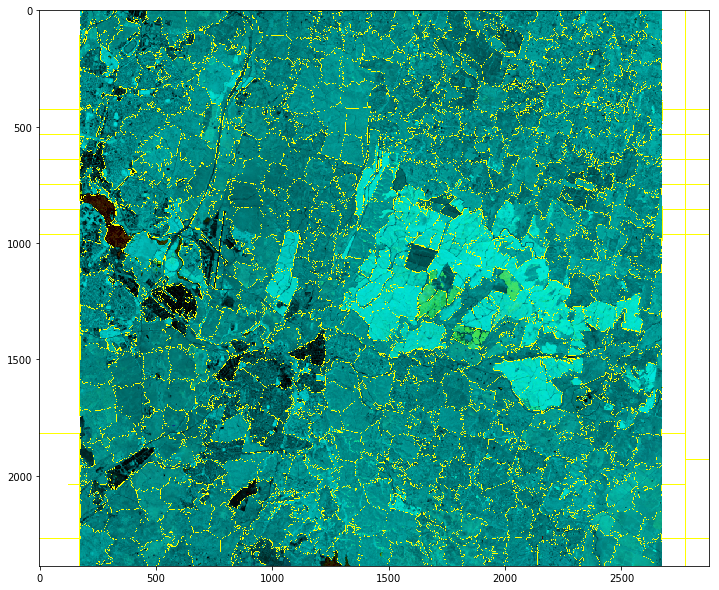

In [13]:
fig, ax = plt.subplots(figsize = (12,12))
cax = ax.imshow(mark_boundaries(scaled, segments))

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


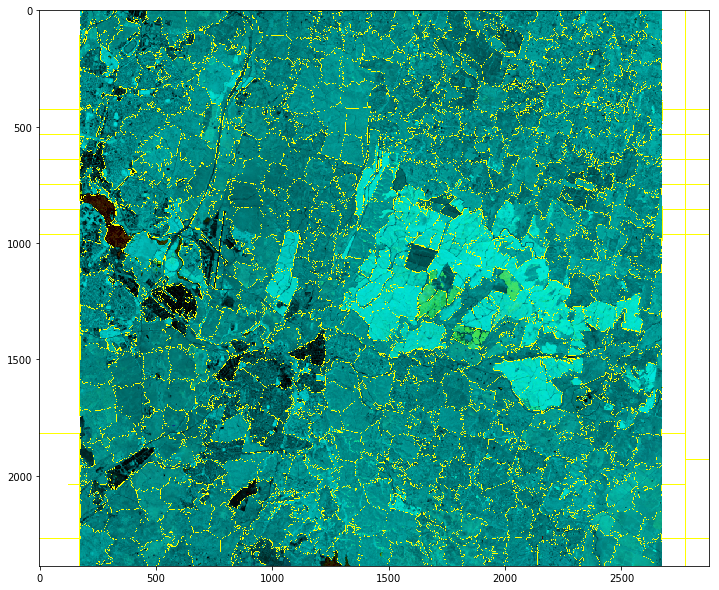

In [14]:
fig, ax = plt.subplots(figsize = (12,12))
cax = ax.imshow(mark_boundaries(data_smad_green, segments))

plt.show()

In [15]:
from skimage.segmentation import felzenszwalb
segments2 = felzenszwalb(data_smad_green, scale=100, sigma=0.95, min_size=5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


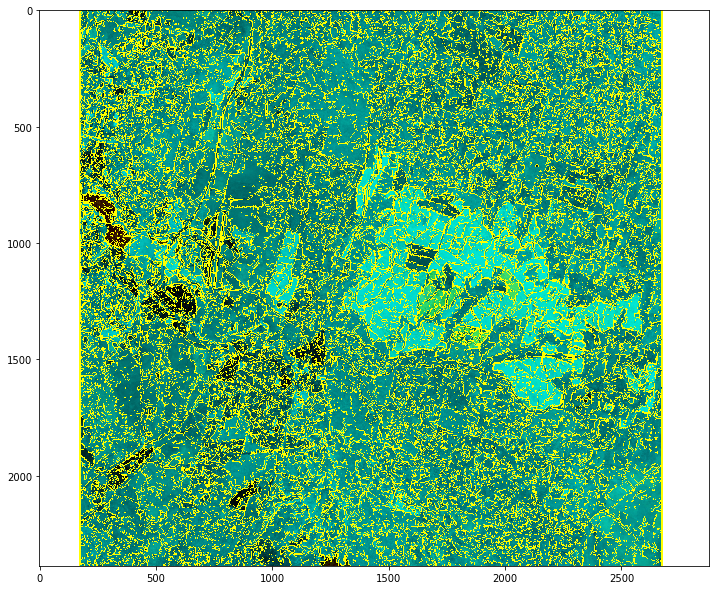

In [16]:
fig, ax = plt.subplots(figsize = (12,12))
cax = ax.imshow(mark_boundaries(scaled, segments2))

plt.show()

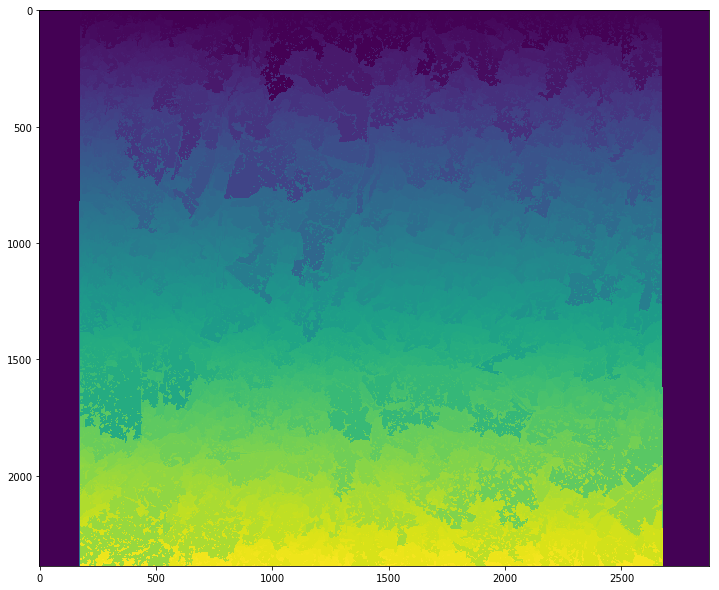

In [17]:
fig, ax = plt.subplots(figsize = (12,12))
cax = ax.imshow(segments2)

plt.show()